<a href="https://colab.research.google.com/github/matheusmughrabi/AnalisadorVinhoTinto/blob/master/Classificador_de_vinhos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

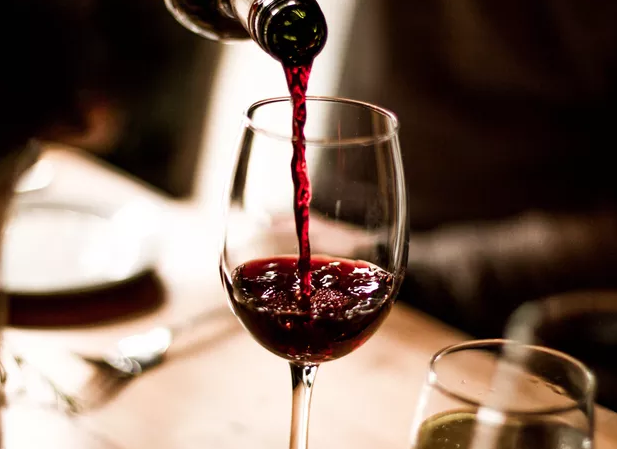

fonte: https://revistacasaejardim.globo.com/Casa-e-Comida/Receber-com-charme/noticia/2020/04/bordeaux-e-borgonha-conheca-diferenca-entre-tacas-de-vinho-tinto.html

## Objetivo do Modelo
O principal objetivo deste notebook é desenvolver um modelo de classificação de machine learning para prever a qualidade dos vinhos.

A qualidade do vinho será classificada em duas categorias: ruim e bom.

Este modelo visa ajudar vinícolas, sommeliers e entusiastas do vinho a entender melhor os fatores que influenciam a qualidade do vinho e a fazer previsões precisas com base em características químicas.

## Importância do Modelo
A indústria do vinho é marcada pela busca constante de qualidade e excelência.

Compreender os fatores que contribuem para a qualidade do vinho é crucial para melhorar os processos de produção e atender às expectativas dos consumidores.

Um modelo preditivo eficaz pode ser uma ferramenta valiosa para prever a qualidade do vinho, auxiliando na tomada de decisões informadas na vinificação, marketing e vendas.

Além disso, oferece insights acadêmicos e comerciais sobre as complexas interações entre os diversos componentes do vinho.

## Sobre o dataset
O dataset utilizado neste notebook está disponível na plataforma Kaggle [Link para o dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/data).

O dataset contém diversos atributos tipicamente notados por apreciadores de vinho, tais como acidez volátil, densidade, e porcentagem de álcool.

Além disso, o dataset possui como variável depende a qualidade do vinho avaliada como uma nota de zero a dez.

Como o objetivo deste notebook é gerar um modelo preditivo de classificação foi gerada uma coluna extra para o notebook chamada de categoria do vinho (wine category).

A categoria do vinho foi definida com base na seguinte regra de negócio:
*   Vinhos com nota menor do que 6 considerados ruins
* Vinhos com nota maior ou igual a 6 são considerados bons


## Estrutura do Notebook
O notebook será estruturado em várias seções, cada uma abordando uma etapa crucial na construção do modelo de classificação:



1.   Carregamento
2. Análise exploratória de dados (EDA)
3.   Limpeza de dados e feature engineering
4. Treinamento do modelo preditivo
5. Avaliação de desempenho
6. Exportação do modelo
6. Conclusões

Ao final deste notebook, esperamos ter um modelo confiável e interpretável que possa prever a qualidade do vinho com precisão, baseado em suas propriedades físico-químicas.

# Introdução às variáveis que compõem o dataset

**Acidez Fixa:** Refere-se aos ácidos que permanecem no vinho após a fermentação, como ácido málico e ácido tartárico. Contribui para a frescura e equilíbrio do vinho.

**Acidez Volátil:** Mede os ácidos que podem evaporar facilmente, como o ácido acético. Níveis elevados podem indicar vinho estragado, mas em pequenas quantidades, pode adicionar complexidade.

**Ácido Cítrico:** Um ácido naturalmente encontrado em uvas, mas às vezes adicionado para ajustar a acidez. Influencia a frescura e o sabor cítrico do vinho.

**Açúcar Residual:** A quantidade de açúcar que não é convertida em álcool durante a fermentação. Influencia a doçura do vinho; vinhos tintos secos têm baixo açúcar residual.

**Cloretos:** Principalmente provenientes do solo, os cloretos podem influenciar o sabor salgado do vinho e sua estabilidade química.

**Dióxido de Enxofre Total:** Inclui formas livres e ligadas de SO2. Usado como conservante, ajuda a manter a frescura e protege contra oxidação e bactérias.

**Densidade:** Relacionada ao teor de açúcar e álcool do vinho. A densidade diminui à medida que o açúcar é fermentado em álcool, sendo um indicador do estágio de fermentação.

**pH:** Mede a acidez do vinho em uma escala de 0 a 14. Um pH baixo significa maior acidez, influenciando a cor, estabilidade e sabor do vinho.

**Sulfatos:** Componentes que podem surgir da adição de sulfitos, utilizados para preservar e proteger o vinho. Níveis elevados podem alterar o sabor e aroma.

**Álcool:** Resulta da fermentação do açúcar pelas leveduras. O teor alcoólico contribui para o corpo, sabor e calor do vinho.

# Importação das bibliotecas e criação das classes

In [1]:
from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from pickle import dump
from imblearn.over_sampling import SMOTE

In [2]:
from typing_extensions import Self

class CarregadorDeDados:
    def __init__(self, url):
        self.url = url
        self.dados = None

    def carregar_dados(self):
        self.dados = pd.read_csv(self.url)
        return self.dados

class CategorizadorDeDados:
    def __init__(self, dados):
        self.dados = dados

    def categorizar_qualidade(self):
      def categorizar(qualidade):
          if qualidade < 6:
              return 'Ruim'
          else:
              return 'Bom'
      self.dados['categoria_qualidade'] = self.dados['quality'].apply(categorizar)

# Classe para Análise Exploratória de Dados
class ExploracaoDeDados:
    def __init__(self, dados):
        self.dados = dados

    def obter_head(self):
        display(self.dados.head(10))

    def obter_descricao(self):
        display(self.dados.describe())

    def verificar_dados_nulos(self):
        print(self.dados.isnull().sum())

    def plotar_histogramas(self):
        num_cols = self.dados.shape[1]
        num_rows = (num_cols + 2) // 3
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(self.dados.columns):
            plt.subplot(num_rows, 3, i + 1)
            sns.histplot(self.dados[col], kde=True)
            plt.title(col)
        plt.tight_layout()
        plt.show()

    def plotar_boxplots(self):
        # Filtrar apenas colunas numéricas
        dados_numericos = self.dados.select_dtypes(include=['float64', 'int64'])

        num_atributos = dados_numericos.shape[1]
        num_cols = 3
        num_rows = (num_atributos + num_cols - 1) // num_cols
        plt.figure(figsize=(15, num_rows * 4))
        for i, col in enumerate(dados_numericos.columns):
            plt.subplot(num_rows, num_cols, i + 1)
            sns.boxplot(y=dados_numericos[col], color='lightblue')
            plt.title(col)
        plt.tight_layout()
        plt.show()


    def analisar_balanceamento_dos_dados(self, *colunas):
        for coluna in colunas:
            category_counts = self.dados[coluna].value_counts()
            plt.figure(figsize=(8, 6))
            sns.barplot(x=category_counts.index, y=category_counts.values)
            plt.title(f'Distribuição da {coluna}')
            plt.xlabel(f'{coluna}')
            plt.ylabel('Número de Ocorrências')
            plt.show()

    def analisar_correlacoes(self):
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.dados.corr(), annot=True, cmap='coolwarm')
        plt.title('Mapa de Calor de Correlações das Variáveis')
        plt.show()

    def analisar_correlacoes_com_qualidade(self, limiar_correlacao, limiar_multicolinearidade):
        # Calcular correlações com a coluna 'quality'
        correlacoes = self.dados.corr()['quality'].abs().sort_values(ascending=False)

        # Selecionar colunas com correlação acima do limiar, excluindo a própria coluna 'quality'
        colunas_interesse = correlacoes[correlacoes > limiar_correlacao].index.tolist()
        colunas_interesse.remove('quality')

        print(f"Colunas selecionadas com base no limiar de correlação ({limiar_correlacao}): {colunas_interesse}")

        # Calculando a matriz de correlação entre as colunas selecionadas
        matriz_corr_selecionadas = self.dados[colunas_interesse].corr()

        # Encontrando pares com alta multicolinearidade
        pares_alta_corr = []

        for i in range(len(matriz_corr_selecionadas.columns)):
            for j in range(i):
                if abs(matriz_corr_selecionadas.iloc[i, j]) >= limiar_multicolinearidade:
                    pares_alta_corr.append((matriz_corr_selecionadas.columns[i], matriz_corr_selecionadas.columns[j], matriz_corr_selecionadas.iloc[i, j]))

        # Exibindo os pares
        print("Pares de variáveis com alta multicolinearidade:")
        for par in pares_alta_corr:
            print(f"{par[0]} - {par[1]}, Correlação: {par[2]:.2f}")

class ProcessadorDeDados:
    def __init__(self, dados):
        self.dados = dados

    def selecionar_colunas_para_manter(self, *colunas_a_manter):
        colunas_a_remover = [col for col in self.dados.columns if col not in colunas_a_manter]
        self.dados.drop(columns=colunas_a_remover, inplace=True)

    def remover_outliers(self):
        Q1 = self.dados.quantile(0.25)
        Q3 = self.dados.quantile(0.75)
        IQR = Q3 - Q1
        self.dados = self.dados[~((self.dados < (Q1 - 1.5 * IQR)) | (self.dados > (Q3 + 1.5 * IQR))).any(axis=1)]

class ConstrutorDeModelos:
    def __init__(self, dados):
        self.dados = dados
        self.modelos = {}
        self.pontuacoes = {}
        self.X_treino, self.X_teste, self.y_treino, self.y_teste = None, None, None, None

    def dividir_dados(self):
        X = self.dados.drop(['quality', 'categoria_qualidade'], axis=1)
        y = self.dados['categoria_qualidade']
        self.X_treino, self.X_teste, self.y_treino, self.y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

    def treinar_modelos(self):
        pipelines = {
            'knn': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
            'arvore': Pipeline([('scaler', MinMaxScaler()), ('arvore', DecisionTreeClassifier(random_state=42))]),
            'naive_bayes': Pipeline([('scaler', StandardScaler()), ('naive_bayes', GaussianNB())]),
        'svm': Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state=42, probability=True))])
        }
        parametros = {
            'knn': {'knn__n_neighbors': [3, 5, 7, 9, 11]},
            'arvore': {'arvore__max_depth': [None, 10, 20, 30, 40], 'arvore__min_samples_split': [2, 5, 10]},
            'naive_bayes': {},
            'svm': {'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 'auto']}
        }
        for nome_modelo in pipelines:
            busca = GridSearchCV(pipelines[nome_modelo], parametros[nome_modelo], cv=5, n_jobs=-1, verbose=1)
            self.modelos[nome_modelo] = busca.fit(self.X_treino, self.y_treino)

    def avaliar_modelos(self):
        for nome_modelo, modelo in self.modelos.items():
            y_pred = modelo.predict(self.X_teste)
            acuracia = accuracy_score(self.y_teste, y_pred)
            precisao = precision_score(self.y_teste, y_pred, average='weighted')
            f1 = f1_score(self.y_teste, y_pred, average='weighted')
            self.pontuacoes[nome_modelo] = f1
            print(f"Pontuações do modelo {nome_modelo}:")
            print(f"  Acurácia: {acuracia:.4f}")
            print(f"  Precisão: {precisao:.4f}")
            print(f"Pontuação F1 do modelo {nome_modelo}: {f1:.4f}")
            print(classification_report(self.y_teste, y_pred))

    def plotar_desempenho(self):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(self.pontuacoes.keys()), y=list(self.pontuacoes.values()))
        plt.title('Comparação de Pontuação F1 dos Modelos')
        plt.ylabel('Pontuação F1')
        plt.xlabel('Modelo')
        plt.show()

    def exportar_melhor_modelo(self, nome_arquivo):
        melhor_modelo = max(self.pontuacoes, key=self.pontuacoes.get)
        dump(self.modelos[melhor_modelo], open(nome_arquivo, 'wb'))

# Classe Principal
class PreditorQualidadeVinho:
    def __init__(self, url):
        self.url = url
        self.carregador_dados = CarregadorDeDados(url)
        self.categorizador_dados = None
        self.processador_dados = None
        self.exploracao_dados = None
        self.construtor_modelos = None

    def carregar_dados(self):
        dados = self.carregador_dados.carregar_dados()
        self.categorizador_dados = CategorizadorDeDados(dados)
        self.exploracao_dados = ExploracaoDeDados(dados)
        self.processador_dados = ProcessadorDeDados(dados)

    def categorizar_dados(self):
        self.categorizador_dados.categorizar_qualidade()

    def obter_head(self):
        self.exploracao_dados.obter_head()

    def obter_descricao(self):
        self.exploracao_dados.obter_descricao()

    def verificar_dados_nulos(self):
        self.exploracao_dados.verificar_dados_nulos()

    def plotar_histogramas(self):
        self.exploracao_dados.plotar_histogramas()

    def plotar_boxplots(self):
        self.exploracao_dados.plotar_boxplots()

    def analisar_correlacoes(self):
        self.exploracao_dados.analisar_correlacoes()

    def analisar_balanceamento_dos_dados(self, *colunas):
        self.exploracao_dados.analisar_balanceamento_dos_dados(*colunas)

    def analisar_correlacoes_com_qualidade(self, limiar_correlacao, limiar_multicolinearidade):
        self.exploracao_dados.analisar_correlacoes_com_qualidade(limiar_correlacao, limiar_multicolinearidade)

    def selecionar_colunas_para_manter(self,*colunas_a_manter):
        self.processador_dados.selecionar_colunas_para_manter(*colunas_a_manter)

    def remover_outliers(self):
        self.processador_dados.remover_outliers()

    def construir_modelos(self):
        self.construtor_modelos = ConstrutorDeModelos(self.processador_dados.dados)
        self.construtor_modelos.dividir_dados()
        self.construtor_modelos.treinar_modelos()

    def avaliar_modelos(self):
        self.construtor_modelos.avaliar_modelos()
        self.construtor_modelos.plotar_desempenho()

    def exportar_melhor_modelo(self, nome_arquivo):
        if self.construtor_modelos is not None:
            melhor_modelo = max(self.construtor_modelos.pontuacoes, key=self.construtor_modelos.pontuacoes.get)
            dump(self.construtor_modelos.modelos[melhor_modelo], open(nome_arquivo, 'wb'))
        else:
            print("Nenhum modelo foi construído e avaliado ainda.")

# Carregamento dos dados

In [3]:
url = 'https://raw.githubusercontent.com/matheusmughrabi/AnalisadorVinhoTinto/master/winequality-red.csv'
preditor = PreditorQualidadeVinho(url)
preditor.carregar_dados()


# Pré-processamento

Nesta etapa de pré-processamento, vamos utilizar uma técnia chamada engenharia de features na qual criaremos uma nova coluna chamada qualidade da categoria

In [4]:
preditor.categorizar_dados()

# Análise exploratória de dados (EDA)

## Análise da estrutura do dataset

In [5]:
preditor.obter_head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,categoria_qualidade
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Ruim
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Ruim
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Ruim
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Bom
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Ruim
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,Ruim
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,Ruim
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,Bom
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,Bom
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,Ruim


## Métricas básicas do dataset

### Análise das Escalas das Variáveis

Ao observar as estatísticas descritivas do dataset, notamos que as variáveis possuem uma ampla gama de escalas. Por exemplo:

A variável 'fixed acidity' varia de 4.6 a 15.9. Em contraste, 'chlorides' varia de 0.012 a 0.611, o que indica uma menor variação absoluta, mas é importante considerar que mesmo pequenas mudanças em concentrações químicas podem ter um impacto notável na qualidade do vinho.

Essas diferenças nas escalas das variáveis indicam a importância da normalização ou padronização, especialmente para algoritmos de machine learning que são sensíveis a variações de escala, como KNN, SVM e redes neurais.

### Análise dos Limites Aceitáveis para as Variáveis do Modelo

Com base na análise estatística do conjunto de dados, podemos estabelecer os seguintes limites aceitáveis para cada variável. Estes limites são determinados considerando os valores de quartis e a distribuição geral dos dados.

- **Acidez Fixa**: Os valores de acidez fixa variam consideravelmente, indicando uma diversidade nos tipos de vinho. Com base nos quartis, valores entre 7.1 e 9.2 são mais comuns. Portanto, este intervalo pode ser considerado ideal para a acidez fixa.

- **Acidez Volátil**: A acidez volátil tem um intervalo mais restrito, sugerindo que valores extremos são menos comuns. Valores típicos variam de 0.39 a 0.64. Valores fora deste intervalo podem indicar características atípicas do vinho.

- **Ácido Cítrico**: Como um componente menos variável, o ácido cítrico varia principalmente entre 0.09 e 0.42. Este intervalo pode ser considerado padrão para a maioria dos vinhos tintos.

- **Açúcar Residual**: O açúcar residual geralmente varia de 1.9 a 2.6 g/dm³. Esse intervalo sugere que a maioria dos vinhos no conjunto de dados tende a ter baixa doçura residual.

- **Cloretos**: Os níveis de cloretos, que variam de 0.07 a 0.09 g/dm³, indicam uma concentração relativamente uniforme neste conjunto de dados, com valores mais altos sendo menos comuns.

- **Dióxido de Enxofre Livre**: Com uma variação de 7 a 14 mg/dm³, o dióxido de enxofre livre mostra uma distribuição mais concentrada, sugerindo um controle padrão na vinificação.

- **Dióxido de Enxofre Total**: Varia de 22 a 62 mg/dm³. Esta faixa sugere um nível comum de conservantes na maioria dos vinhos.

- **Densidade**: A densidade do vinho varia tipicamente de 0.996 a 0.9978 g/cm³. Esta é uma faixa estreita, refletindo o equilíbrio entre açúcar, álcool e água no vinho.

- **pH**: O pH, que influencia a acidez percebida do vinho, varia normalmente de 3.21 a 3.40. Este intervalo representa o equilíbrio ácido típico para vinhos tintos.

- **Sulfatos**: Os sulfatos variam de 0.62 a 0.73 g/dm³, indicando o uso comum de sulfitos como conservantes e estabilizantes no vinho.

- **Álcool**: Os níveis de álcool variam de 9.5% a 10.2%. Este intervalo é característico de vinhos tintos, onde o álcool desempenha um papel significativo no corpo e no sabor.

Esses limites baseiam-se nas características comuns observadas no conjunto de dados e devem ser considerados como orientações gerais. Variações podem ser esperadas com base em diferentes tipos de vinho e processos de vinificação.


In [6]:
preditor.obter_descricao()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


O dataset não possui nenhum valor nulo, dessa forma não iremos nos preocupar em tratar dados nulos para melhorar o desempenho do modelo preditivo.

In [7]:
preditor.verificar_dados_nulos()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
categoria_qualidade     0
dtype: int64


Abaixo podemos ver que os atributos têm escalas variadas.

Por exemplo, 'fixed acidity' varia de 4.6 a 15.9, enquanto 'chlorides' varia de 0.012 a 0.611.

Esta variação na escala sugere que a normalização pode ser benéfica, especialmente para algoritmos sensíveis à escala dos dados.

Alguns atributos, como 'volatile acidity' e 'sulphates', parecem ter uma distribuição assimétrica.

A padronização pode ser útil para algoritmos que pressupõem uma distribuição normal dos dados.

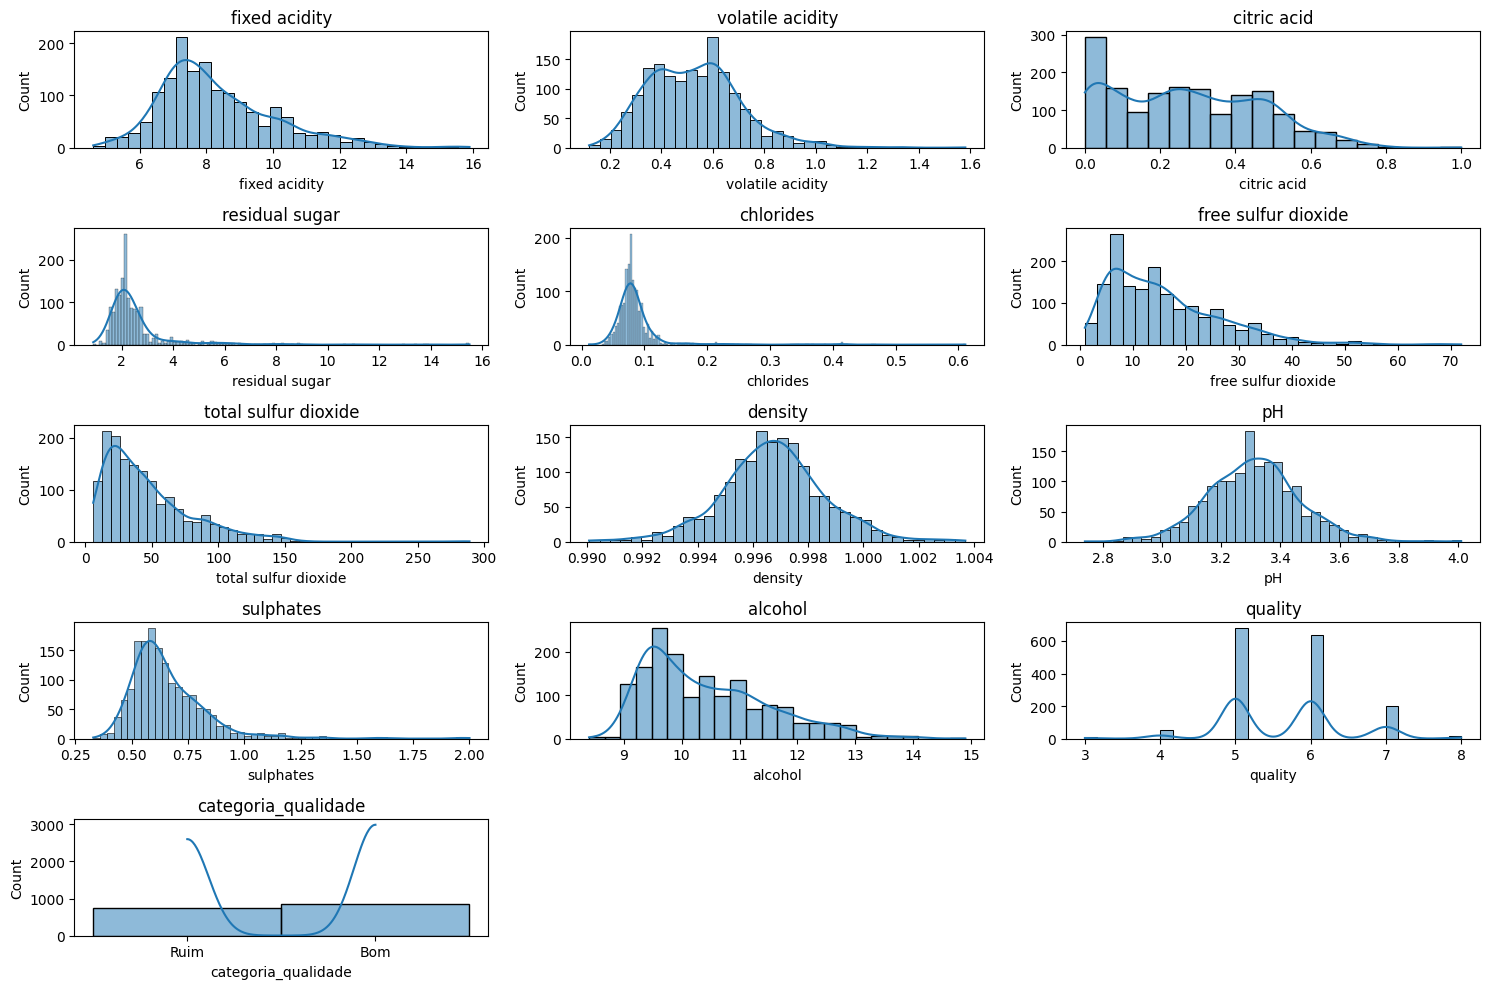

In [8]:
preditor.plotar_histogramas()

A seguir vamos iniciar a nossa busca por outliers em nosso dataset.

O boxplot abaixo nos ajuda a ter um primeiro contato com os outliers, estes são representados por pontos cinza em cada boxplot.

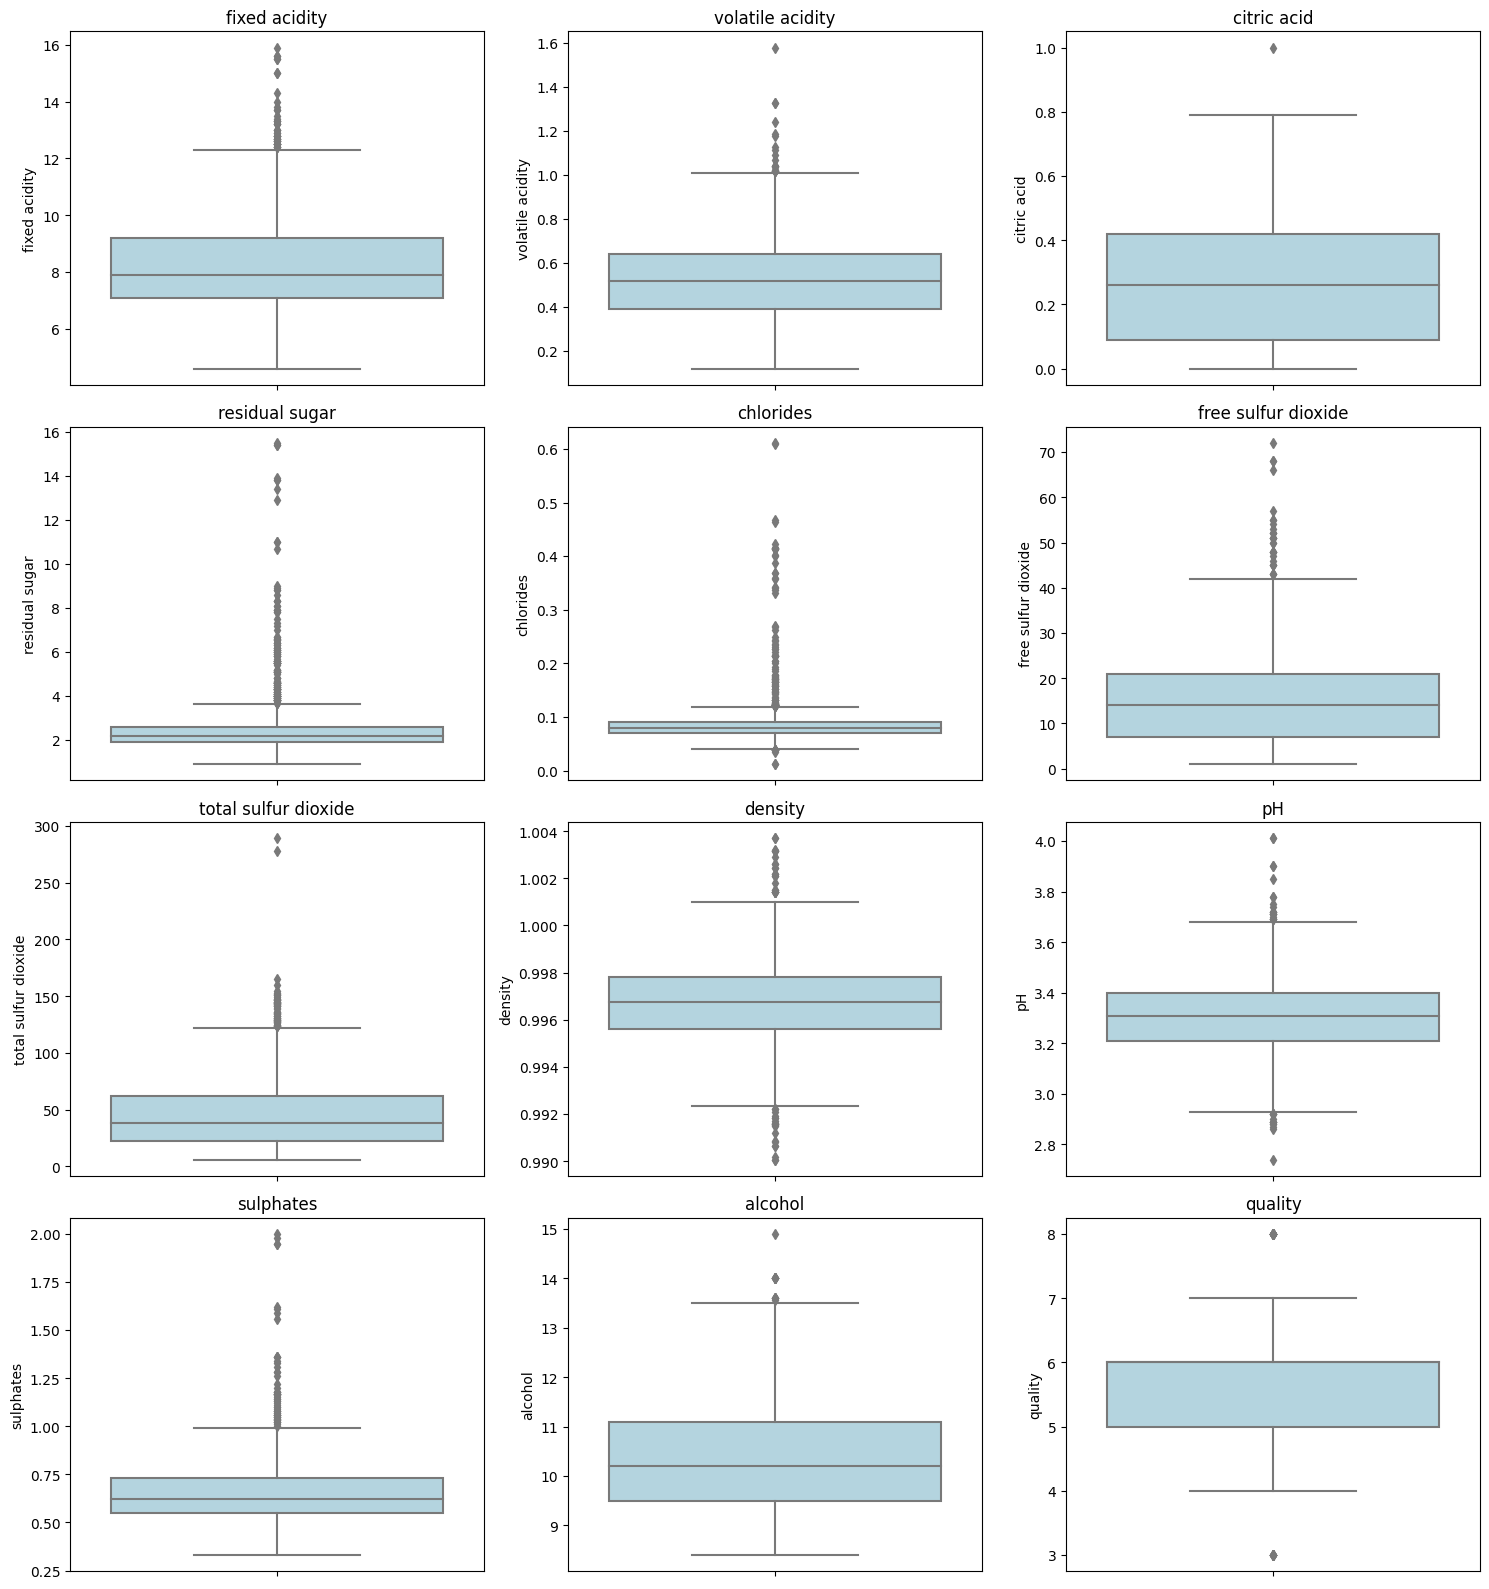

In [9]:
preditor.plotar_boxplots()

Nota-se uma forte predominância de notas 5 e 6 para os vinhos do dataset, o que caracteriza um conjunto de dados desbalanceado.
Entretanto, do ponto de vista da categoria de qualidade do vinho, nota-se um bom balanceamento dos dados.

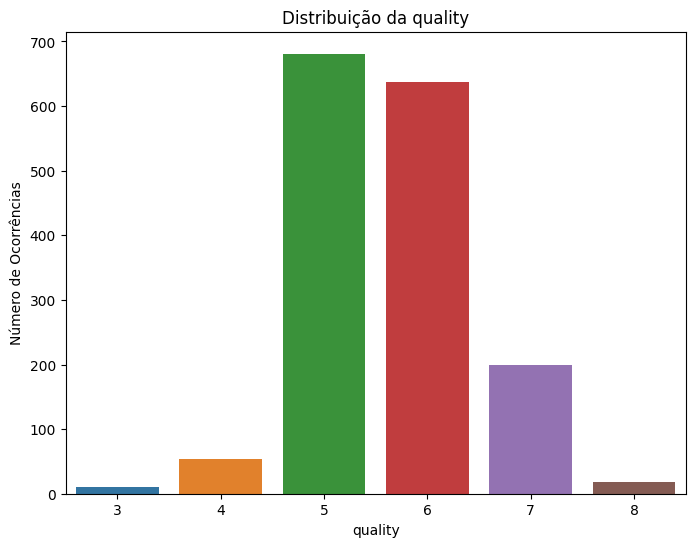

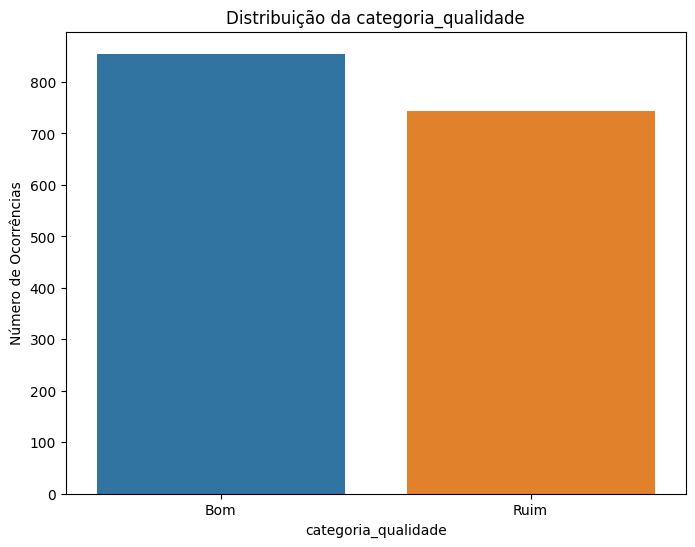

In [10]:
preditor.analisar_balanceamento_dos_dados('quality', 'categoria_qualidade')

## Análise de correlações entre as variáveis


###Correlações com a Qualidade do Vinho (Quality)

#### Acidez fixa (Fixed Acidity):
*   Correlação: Positiva e moderada
*   Análise: Uma maior porcentagem de acidez fixa tende a estar associada a uma maior qualidade do vinho.


#### Acidez Volátil (Volatile Acidity):
* Correlação: Negativa e significativa.
  
* Análise: Níveis mais baixos de acidez volátil estão associados a uma qualidade mais alta, indicando que esta variável é crucial para prever a qualidade do vinho.

#### Ácido Cítrico (Citric Acid):
* Correlação: Positiva, mas não muito forte.
* Análise: Um maior conteúdo de ácido cítrico pode levar a uma qualidade melhor, embora seu impacto seja menor em comparação com o álcool ou a acidez volátil.

#### Açúcar Residual (Residual Sugar):
* Correlação: Positiva, mas muito baixa.
* Análise: Esta variável têm um impacto limitado na qualidade do vinho, o que sugere que pode ser menos importantes na modelagem preditiva.

#### Cloretos (Chlorides):
* Correlação: Negativa e moderada.
* Análise: Esta variável pode desempenhar um papel na determinação da qualidade do vinho, mas seu impacto é menos pronunciado do que o do álcool ou da acidez volátil.

#### Açúcar Residual (Residual Sugar):
* Correlação: Negativa, mas muito baixa.
* Análise: Esta variáveil tem um impacto limitado na qualidade do vinho, o que sugere que pode ser menos importante na modelagem preditiva.

#### Dióxido de Enxofre Total (Total Sulfur Dioxide):
* Correlação: Negativa e moderada.
* Análise: Esta variável tem um impacto moderado na qualidade do vinho e pode ser importante para a criação do modelo preditivo.

#### Densidade (Density):
* Correlação: Negativa e moderada.
* Análise: Esta variável tem um impacto moderado na qualidade do vinho e pode ser importante para a criação do modelo preditivo.

#### pH:
* Correlação: Negativa e muito baixo.
* Análise: Esta variáveil tem um impacto limitado na qualidade do vinho, o que sugere que pode ser menos importante na modelagem preditiva.


#### Sulfatos (Sulphates):
* Correlação: Moderada com a qualidade.
* Análise: Esta variável tem um impacto moderado na qualidade do vinho e pode ser importante para a criação do modelo preditivo.


#### Álcool (Alcohol):
* Correlação: Positiva e muito forte.
* Análise: Uma maior porcentagem de álcool tende a estar associada a uma maior qualidade do vinho. Esta é uma variável importante para a modelagem.

A partir desta análise, podemos concluir que as variáveis candidatas para serem utilizadas no modelo preditivo são (em ordem de importância):
1. Álcool
2. Acidez volátil
3. Sulfatos
4. Ácido cítrico
5. Dióxido de enxofre total
6. Densidade
7. Cloretos
8. Acidez fixa

<ipython-input-2-67959f1600d8>:77: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(self.dados.corr(), annot=True, cmap='coolwarm')


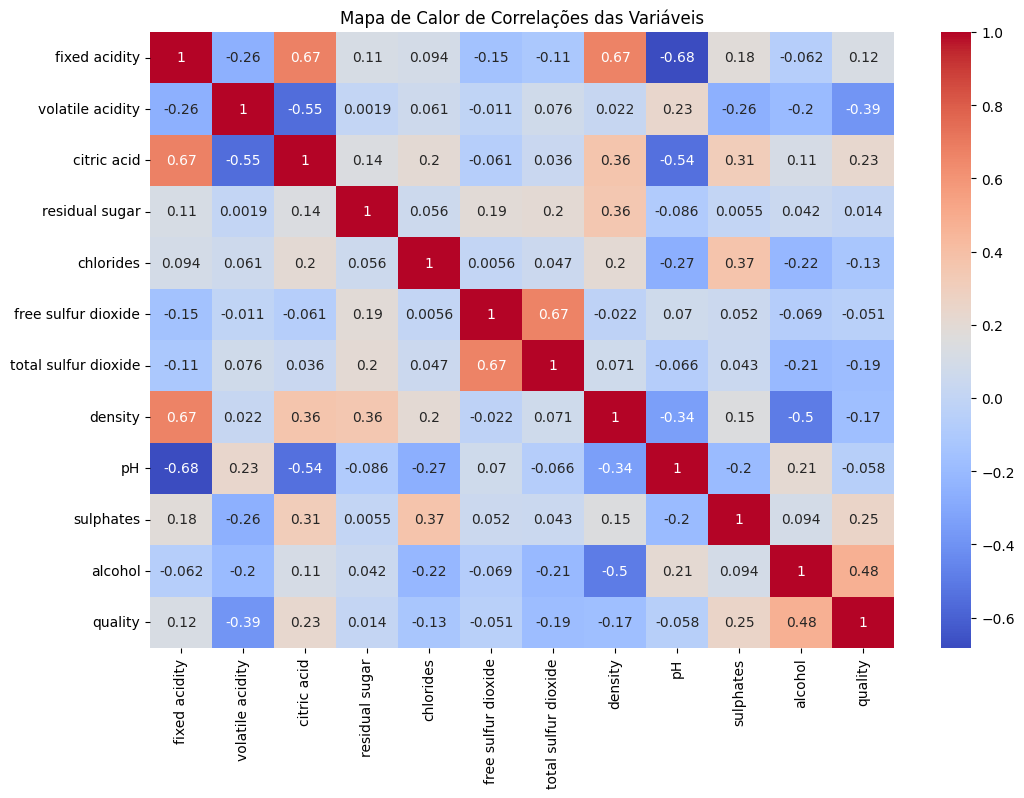

In [11]:
preditor.analisar_correlacoes()

### Multicolinearidade entre Variáveis

Vamos analisar agora a multicolinearidade entre as variáveis candidatas do modelo preditivo.
Esta análise é importante, pois multicolinearidade forte entre variáveis pode prejudicar o desempenho de modelos preditivos a depender do algorítmo utilizado.

Ao definir 0.4 como um limite aceitável para multicolinearidade entre variáveis, observa-se os 4 pares de variáveis abaixo com alta multicolinearidade:

* Acido cítrico e acidez fixa: 0.67
* Ácido cítrico e acidez volátil: -0.55
* Densidade e acidez fixa: 0.67
* Densidade e álcool: -0.50

Como o álcool e a acidez volátil são as variáveis com maior importância para a construção do modelo preditivo, vamos eliminar as variáveis Ácido cítrico e dendidade.


In [12]:
preditor.analisar_correlacoes_com_qualidade(0.1, 0.4)

Colunas selecionadas com base no limiar de correlação (0.1): ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'total sulfur dioxide', 'density', 'chlorides', 'fixed acidity']
Pares de variáveis com alta multicolinearidade:
citric acid - volatile acidity, Correlação: -0.55
density - alcohol, Correlação: -0.50
fixed acidity - citric acid, Correlação: 0.67
fixed acidity - density, Correlação: 0.67


<ipython-input-2-67959f1600d8>:83: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacoes = self.dados.corr()['quality'].abs().sort_values(ascending=False)


### Seleção das colunas mais importantes
A partir das análises de correlação de cada variável do dataset com a qualidade do vinho e da análise de multicolinearidade entre as variáveis, optou-se por utilizar o seguinte subconjunto de variáveis para fazer parte do modelo preditivo:

1. Álcool
2. Acidez volátil
3. Sulfatos
4. Dióxido de enxofre total
5. Cloretos
6. Acidez fixa

# Limpeza de dados e engenharia de features

Como vimos anteriormente, vamos utilizar apenas um subconjunto das colunas do dataset para o modelo preditivo.

In [13]:
preditor.selecionar_colunas_para_manter('fixed acidity',	'volatile acidity',	'chlorides',	'total sulfur dioxide',	'sulphates',	'alcohol', 'quality', 'categoria_qualidade')

Para remover outliers, podemos excluir as linhas do dataset que contêm pelo menos um outlier.

Após a remoção de outliers, o tamanho do dataset foi reduzido de 1599 para 1179 registros, o que significa que 420 linhas contendo pelo menos um outlier foram removidas.

In [14]:
preditor.remover_outliers()

<ipython-input-2-67959f1600d8>:116: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = self.dados.quantile(0.25)
<ipython-input-2-67959f1600d8>:117: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = self.dados.quantile(0.75)
<ipython-input-2-67959f1600d8>:119: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  self.dados = self.dados[~((self.dados < (Q1 - 1.5 * IQR)) | (self.dados > (Q3 + 1.5 * IQR))).any(axis=1)]


# Treinamento do modelo preditivo

1. Preparação dos Dados para Treinamento

  Antes do treinamento dos modelos, o método construir_modelos() inicia com a preparação dos dados. Esta etapa envolve:

  Divisão dos dados: O conjunto de dados é dividido em dois subconjuntos: dados de treinamento e dados de teste. Esta divisão é crucial para avaliar o desempenho do modelo em dados não vistos, garantindo uma avaliação justa da capacidade de generalização do modelo.

  Separação de características e alvos: As características (ou features) são separadas do alvo (ou label), que neste caso é a categoria_qualidade dos vinhos. As características são utilizadas como entrada para o modelo, enquanto o alvo é o que o modelo tentará prever.

2. Definição e Configuração dos Modelos

  Vários modelos de classificação são definidos e configurados para o treinamento. Cada modelo representa uma abordagem diferente para o problema de classificação. Os modelos incluem:

  K-Nearest Neighbors (KNN): Um modelo simples, porém eficaz, que classifica uma amostra com base na maioria das classes de seus vizinhos mais próximos.

  Árvore de Decisão: Um modelo que cria uma estrutura em forma de árvore, onde cada nó representa uma decisão baseada nas características dos dados.

  Naive Bayes: Um modelo baseado em probabilidades que aplica o teorema de Bayes, assumindo independência entre as características.

  Support Vector Machine (SVM): Um modelo poderoso que busca encontrar um hiperplano em um espaço de alta dimensão que melhor separa as classes.

  Para cada um desses modelos, são aplicados pipelines que incluem etapas de pré-processamento, como a normalização ou padronização dos dados, que são essenciais para alguns algoritmos, como KNN e SVM.

3. Otimização de Hiperparâmetros

  Para cada modelo, uma busca por hiperparâmetros é realizada usando o GridSearchCV. Esta técnica realiza uma busca exaustiva sobre um espaço de hiperparâmetros especificado. Por exemplo:

  Para o KNN, diferentes números de vizinhos são testados.

  Para a Árvore de Decisão, diferentes profundidades da árvore e mínimos números de amostras para dividir um nó são avaliados.

  Para o SVM, diferentes valores de C (regularização) e gamma são explorados.

  O GridSearchCV utiliza validação cruzada para garantir que a avaliação dos hiperparâmetros seja robusta e menos suscetível a variações nos dados de treinamento.

4. Treinamento dos Modelos

  Após a configuração, cada modelo é treinado com os dados de treinamento. Durante o treinamento, os modelos aprendem a relação entre as características dos vinhos e suas qualidades.


In [ ]:
preditor.construir_modelos()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


# Avaliação de desempenho do modelo

## Visão Geral

 A métrica principal usada para avaliar o desempenho foi a pontuação F1, que harmoniza as métricas de precisão e recall em uma única medida.

## Análise de Desempenho

  Pontuações F1

  Support Vector Machine (SVM): 0.7765

  K-Nearest Neighbors (KNN): 0.7710

  Árvore de Decisão: 0.7690

  Naive Bayes: 0.7540

## Interpretação das Pontuações
O modelo SVM apresentou a maior pontuação F1 de 0.7765, indicando um equilíbrio superior entre precisão e recall. Esta pontuação sugere que o SVM é eficaz em classificar corretamente as categorias de qualidade dos vinhos, minimizando tanto os falsos positivos quanto os falsos negativos.

O KNN e a Árvore de Decisão mostraram desempenhos semelhantes com pontuações F1 de 0.7710 e 0.7690, respectivamente. Esses resultados indicam que ambos os modelos são bastante competentes, mas com uma ligeira inclinação para a ocorrência de mais falsos positivos ou falsos negativos em comparação com o SVM.

O Naive Bayes, com uma pontuação F1 de 0.7540, teve um desempenho um pouco inferior aos outros modelos. Isso pode ser atribuído à sua natureza de assumir independência entre os atributos, uma suposição que pode não ser inteiramente verdadeira para os dados de vinho.

Pontuações do modelo knn:
  Acurácia: 0.7708
  Precisão: 0.7713
Pontuação F1 do modelo knn: 0.7710
              precision    recall  f1-score   support

         Bom       0.80      0.79      0.79       223
        Ruim       0.73      0.75      0.74       174

    accuracy                           0.77       397
   macro avg       0.77      0.77      0.77       397
weighted avg       0.77      0.77      0.77       397

Pontuações do modelo arvore:
  Acurácia: 0.7683
  Precisão: 0.7723
Pontuação F1 do modelo arvore: 0.7690
              precision    recall  f1-score   support

         Bom       0.82      0.76      0.79       223
        Ruim       0.72      0.78      0.75       174

    accuracy                           0.77       397
   macro avg       0.77      0.77      0.77       397
weighted avg       0.77      0.77      0.77       397

Pontuações do modelo naive_bayes:
  Acurácia: 0.7531
  Precisão: 0.7658
Pontuação F1 do modelo naive_bayes: 0.7539
              precision    

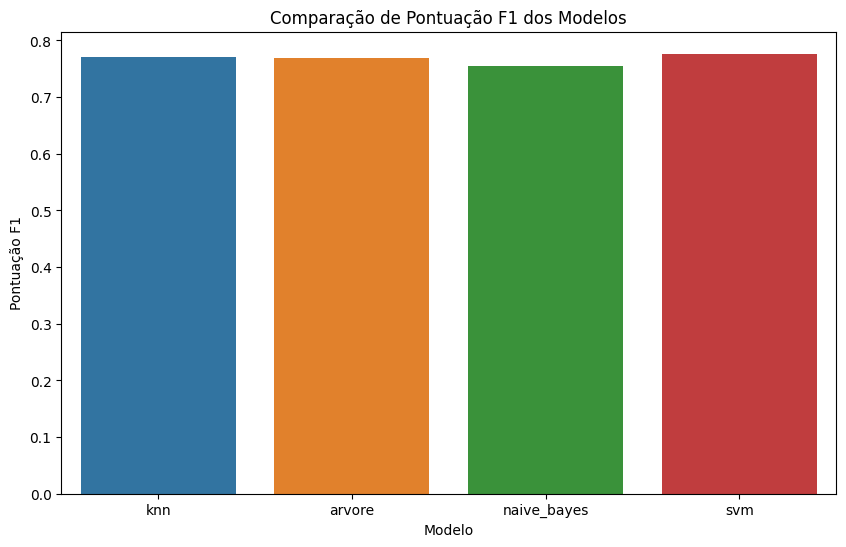

In [ ]:
preditor.avaliar_modelos()

# Exportação do modelo

In [ ]:
preditor.exportar_melhor_modelo('modelo_preditivo.pkl')

# Conclusões
Neste projeto, desenvolvemos um modelo de classificação de machine learning para prever a qualidade dos vinhos classificados como Ruim ou Bom. Após uma análise exploratória detalhada e tratamento de dados, incluindo a remoção de outliers e normalização, aplicamos quatro algoritmos diferentes: KNN, Árvore de Decisão, Naive Bayes e SVM.

Cada modelo foi otimizado com busca de hiperparâmetros e avaliado com base em métricas como o F1-score. O modelo de Árvore de Decisão apresentou o melhor desempenho entre os avaliados, indicando ser uma escolha promissora para a predição da qualidade do vinho com base em suas características físico-químicas.

Este modelo oferece insights valiosos para a indústria do vinho, podendo auxiliar vinícolas e sommeliers nas decisões de produção e avaliação de qualidade. No entanto, é importante ressaltar que a qualidade do vinho pode ser influenciada por fatores não capturados neste modelo, como as condições de armazenamento e transporte.

Para futuras melhorias, recomendamos a inclusão de mais variáveis relacionadas ao processo de vinificação e teste de modelos mais avançados de machine learning, como redes neurais. Além disso, seria interessante aplicar o modelo a outros tipos de vinho para avaliar sua generalização.

Por fim, é importante lembrar a importância de levar em consideração os limites aceitáveis de cada variável do modelo. Estes limites foram explicados em detalhes na seção "Análise dos Limites Aceitáveis para as Variáveis do Modelo". Caso o modelo seja alimentado com valores fora destes limites, a confiabilidade dos resultados não poderá ser garantida.